In [1]:
# Import all relevant libraries
import re
import ast

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

from OpenAIHandler.openai_handler import OpenAIHandler

## Principal Component Analysis (PCA) on Skills

#### Clean the Dataset

In [2]:
def preprocess_dataframe(df, categorical_features=None, numerical_features=None):

    df_encoded = pd.DataFrame(index=df.index)

    # Process numerical features
    if numerical_features:
        # Ensure the numerical columns exist in the DataFrame
        numerical_cols = [col for col in numerical_features if col in df.columns]
        if numerical_cols:
            # Scale numerical features to 0-1 range
            scaler = MinMaxScaler()
            df_numerical = df[numerical_cols].copy()
            df_numerical_scaled = pd.DataFrame(
                scaler.fit_transform(df_numerical),
                columns=numerical_cols,
                index=df.index
            )
            df_encoded = pd.concat([df_encoded, df_numerical_scaled], axis=1)
        else:
            print("No numerical columns found in the DataFrame.")

    # Process categorical features
    if categorical_features:
        # Ensure the categorical columns exist in the DataFrame
        categorical_cols = [col for col in categorical_features if col in df.columns]
        if categorical_cols:
            # One-hot encode categorical features
            df_categorical = df[categorical_cols].copy()
            df_categorical_encoded = pd.get_dummies(
                df_categorical,
                columns=categorical_cols,
                drop_first=False
            ).astype(int)
            df_encoded = pd.concat([df_encoded, df_categorical_encoded], axis=1)
        else:
            print("No categorical columns found in the DataFrame.")

    if df_encoded.empty:
        print("No features to encode. The returned DataFrame is empty.")

    return df_encoded


### Select Clustering Method

In [3]:
def find_best_clustering_method(df_encoded, n_clusters=3):
    
    silhouette_scores = {}

    # 1. K-Means Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=123)
    kmeans_labels = kmeans.fit_predict(df_encoded)
    silhouette_scores['K-Means'] = silhouette_score(df_encoded, kmeans_labels)

    # 2. Agglomerative Clustering
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    agglo_labels = agglo.fit_predict(df_encoded)
    silhouette_scores['Agglomerative'] = silhouette_score(df_encoded, agglo_labels)

    # 3. DBSCAN Clustering
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(df_encoded)

    # Check if DBSCAN found any clusters (dbscan labels might contain -1 for noise points)
    if len(set(dbscan_labels)) > 1:  
        silhouette_scores['DBSCAN'] = silhouette_score(df_encoded, dbscan_labels)
    else:
        silhouette_scores['DBSCAN'] = -1  # If DBSCAN doesn't find clusters, we give it a low score

    # 4. Spectral Clustering
    spectral = SpectralClustering(n_clusters=n_clusters, random_state=123, affinity='nearest_neighbors')
    spectral_labels = spectral.fit_predict(df_encoded)
    silhouette_scores['Spectral'] = silhouette_score(df_encoded, spectral_labels)

    # Determine the best clustering method based on the highest silhouette score
    best_method = max(silhouette_scores, key=silhouette_scores.get)
    
    return best_method


#### K-Means

In [4]:
def tune_and_apply_kmeans_clustering(df_encoded, df_original, cluster_range=range(2, 5), n_inits=[10, 50, 100], max_iters=[300, 500, 1000], algorithms=['lloyd', 'elkan']):

    # Step 1: Find the optimal number of clusters based on silhouette scores
    inertia = []
    silhouette_scores = []
    
    # Loop over the range of cluster numbers and compute the inertia and silhouette score for each
    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=123)
        cluster_labels = kmeans.fit_predict(df_encoded)
        
        # Append inertia (within-cluster sum of squares)
        inertia.append(kmeans.inertia_)
        
        # Compute the silhouette score and append it
        silhouette_avg = silhouette_score(df_encoded, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    # Determine the optimal number of clusters based on the silhouette score
    optimal_n_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]
    
    # Step 2: Tune K-Means hyperparameters (n_init, max_iter, algorithm)
    best_score = -1
    best_params = {}
    
    # Try different combinations of hyperparameters
    for n_init in n_inits:
        for max_iter in max_iters:
            for algorithm in algorithms:
                kmeans = KMeans(n_clusters=optimal_n_clusters, n_init=n_init, max_iter=max_iter, algorithm=algorithm, random_state=123)
                cluster_labels = kmeans.fit_predict(df_encoded)
                
                # Compute silhouette score
                silhouette_avg = silhouette_score(df_encoded, cluster_labels)
                
                # If this combination is better, save it
                if silhouette_avg > best_score:
                    best_score = silhouette_avg
                    best_params = {
                        'n_init': n_init,
                        'max_iter': max_iter,
                        'algorithm': algorithm,
                        'silhouette_score': silhouette_avg
                    }
       
    # Step 3: Apply K-Means with the best parameters
    kmeans_final = KMeans(n_clusters=optimal_n_clusters, n_init=best_params['n_init'], max_iter=best_params['max_iter'], algorithm=best_params['algorithm'], random_state=42)
    kmeans_clusters = kmeans_final.fit_predict(df_encoded)
    
    # Assign cluster labels to df_encoded
    df_original['Cluster'] = kmeans_clusters
    
    # Return the DataFrame with cluster assignments, the best parameters, and the optimal number of clusters
    return df_original, optimal_n_clusters

#### Agglomerative Clustering

In [5]:
def tune_and_apply_agglomerative_clustering(df_encoded, df_original, n_clusters_range=[2, 3, 4, 5], linkage_methods=['ward', 'complete', 'average', 'single']):
    # Dictionary to store silhouette scores for each combination of n_clusters and linkage
    silhouette_scores = {}

    # Iterate over all combinations of hyperparameters
    for n_clusters in n_clusters_range:
        for linkage in linkage_methods:
            try:
                # Apply Agglomerative Clustering with different hyperparameters
                agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
                clusters = agglo.fit_predict(df_encoded)
                
                # Compute silhouette score
                score = silhouette_score(df_encoded, clusters)
                
                # Store the result
                silhouette_scores[(n_clusters, linkage)] = score
            except Exception as e:
                # Handle errors, for example, some linkage methods might raise errors
                silhouette_scores[(n_clusters, linkage)] = None
                print(f"Error with n_clusters={n_clusters} and linkage={linkage}: {e}")

    # Find the best combination of n_clusters and linkage based on the silhouette score
    best_n_clusters, best_linkage = max(silhouette_scores, key=lambda x: silhouette_scores[x] if silhouette_scores[x] is not None else -1)
    best_score = silhouette_scores[(best_n_clusters, best_linkage)]


    # Apply Agglomerative Clustering with the best parameters
    best_agglo = AgglomerativeClustering(n_clusters=best_n_clusters, linkage=best_linkage)
    df_original['Cluster'] = best_agglo.fit_predict(df_encoded)

    # Return the DataFrame with cluster labels and the best hyperparameters
    return df_original, best_n_clusters


#### Spectral Clustering

In [6]:
def tune_and_apply_spectral_clustering(
    df_encoded, 
    df_original, 
    n_clusters_range=[2, 3, 4, 5], 
    affinity_options=['rbf', 'nearest_neighbors'], 
    gamma_values=[0.1, 1, 10],  # For RBF kernel
    n_neighbors_values=[5, 10, 15]  # For nearest neighbors
):
    
    best_score = -1
    best_params = {}

    # Loop over the range of hyperparameters
    for n_clusters in n_clusters_range:
        for affinity in affinity_options:
            for gamma in gamma_values if affinity == 'rbf' else [None]:
                for n_neighbors in n_neighbors_values if affinity == 'nearest_neighbors' else [None]:
                    
                    # Apply Spectral Clustering with current hyperparameters
                    spectral_clustering = SpectralClustering(
                        n_clusters=n_clusters, 
                        affinity=affinity, 
                        gamma=gamma if gamma is not None else 1,  # Default gamma=1 if not using 'rbf'
                        n_neighbors=n_neighbors if n_neighbors is not None else 10,  # Default n_neighbors=10
                        assign_labels='kmeans',
                        random_state=42
                    )
                    
                    try:
                        # Fit and predict
                        clusters = spectral_clustering.fit_predict(df_encoded)
                        
                        # Calculate silhouette score
                        score = silhouette_score(df_encoded, clusters)
                        
                        # Update best score and parameters if this combination is better
                        if score > best_score:
                            best_score = score
                            best_params = {
                                'n_clusters': n_clusters,
                                'affinity': affinity,
                                'gamma': gamma if gamma is not None else 'default',
                                'n_neighbors': n_neighbors if n_neighbors is not None else 'default',
                                'silhouette_score': score
                            }
                    
                    except Exception as e:
                        # Handle possible errors (e.g., when the model doesn't converge)
                        print(f"Error for n_clusters={n_clusters}, affinity={affinity}, gamma={gamma}, n_neighbors={n_neighbors}: {e}")
                        continue

    # Print the best hyperparameters and silhouette score
    print(f"Best hyperparameters: {best_params}")

    # Apply Spectral Clustering with the best hyperparameters
    spectral_clustering = SpectralClustering(
        n_clusters=best_params['n_clusters'],
        affinity=best_params['affinity'],
        gamma=best_params['gamma'] if best_params['affinity'] == 'rbf' else None,
        assign_labels='kmeans',
        random_state=42
    )
    
    # Fit and predict the clusters with the best parameters
    spectral_clusters = spectral_clustering.fit_predict(df_encoded)
    
    # Assign cluster labels to the cleaned DataFrame
    df_original['Cluster'] = spectral_clusters
    
    # Return the DataFrame with clusters
    return df_original, n_clusters


#### DBSCAN

In [7]:
def tune_and_apply_dbscan_clustering(
    df_encoded, 
    df_original, 
    max_clusters=7, 
    eps_values=[0.1, 0.2, 0.3, 0.5, 1], 
    min_samples_values=[5, 10, 15]
):
    best_score = -1
    best_params = {}
    best_labels = None
    best_n_clusters = 0

    # Iterate over eps and min_samples combinations
    for eps in eps_values:
        for min_samples in min_samples_values:
            try:
                # Apply DBSCAN with current parameters
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                labels = dbscan.fit_predict(df_encoded)

                # Check if DBSCAN found clusters (it can label all points as noise, i.e., -1)
                if len(set(labels)) > 1:  # Exclude if all points are noise
                    # Count the number of clusters (excluding noise labeled as -1)
                    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                    
                    # Only consider configurations within the desired maximum number of clusters
                    if n_clusters <= max_clusters:
                        # Compute the silhouette score (only if more than one cluster)
                        if n_clusters > 1:
                            score = silhouette_score(df_encoded, labels)
                        else:
                            score = -1  # Silhouette score is not defined for a single cluster

                        # Update if this configuration has a better silhouette score
                        if score > best_score:
                            best_score = score
                            best_params = {'eps': eps, 'min_samples': min_samples}
                            best_labels = labels
                            best_n_clusters = n_clusters

            except Exception as e:
                print(f"Error with eps={eps} and min_samples={min_samples}: {e}")
                continue

    if best_labels is None:
        print(f"DBSCAN did not find suitable clusters within the maximum of {max_clusters} clusters.")
        return df_original.copy(), 0

    # Assign cluster labels to a copy of df_original to avoid modifying the original DataFrame
    df_with_clusters = df_original.copy()
    df_with_clusters['Cluster'] = best_labels

    print(f"Best parameters: eps={best_params['eps']}, min_samples={best_params['min_samples']}, Silhouette Score={best_score}")
    print(f"Number of clusters found (excluding noise): {best_n_clusters}")

    # Return the DataFrame with clusters and the number of clusters found
    return df_with_clusters, best_n_clusters


#### Get Clustering Methods

In [8]:
def run_best_clustering_method(df_encoded, df_cleaned):

    # Step 1: Find the best clustering method
    best_method = find_best_clustering_method(df_encoded)

    # Step 2: Run the best clustering method
    if best_method == 'K-Means':
        # Run K-Means clustering
        df_with_clusters, n_clusters = tune_and_apply_kmeans_clustering(df_encoded, df_cleaned)
    elif best_method == 'Agglomerative':
        # Run Agglomerative clustering
        df_with_clusters, n_clusters = tune_and_apply_agglomerative_clustering(df_encoded, df_cleaned)
    elif best_method == 'Spectral':
        # Run Spectral clustering
        df_with_clusters, n_clusters = tune_and_apply_spectral_clustering(df_encoded, df_cleaned)
    elif best_method == 'DBSCAN':
        # Run DBSCAN clustering
        df_with_clusters, n_clusters = tune_and_apply_dbscan_clustering(df_encoded, df_cleaned)
    else:
        # Fallback if no valid clustering method is selected
        df_with_clusters, n_clusters = None, None
        print(f"Clustering method '{best_method}' was selected but could not be applied.")

    # Return the best method, DataFrame with clusters, and the number of clusters
    return best_method, df_with_clusters, n_clusters


### PCA Analysis

In [9]:
def plot_pca_clusters(df, features, showConvexHull=False, showCentroids=False, showMetrics=False):
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    from sklearn.metrics import silhouette_score, calinski_harabasz_score
    from scipy.spatial import ConvexHull
    import numpy as np
    import pandas as pd

    # Extract the features for PCA
    X = df[features]

    # Apply PCA
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(
        data=principalComponents,
        columns=['PC1', 'PC2'],
        index=df.index
    )

    # Add cluster labels
    principalDf['Cluster'] = df['Cluster']

    # Plotting
    plt.figure(figsize=(10, 8))
    clusters = principalDf['Cluster'].unique()
    colors = plt.cm.get_cmap('tab10', len(clusters))

    for idx, cluster in enumerate(clusters):
        indices = principalDf['Cluster'] == cluster
        cluster_points = principalDf.loc[indices, ['PC1', 'PC2']]

        # Plot cluster points
        plt.scatter(
            cluster_points['PC1'],
            cluster_points['PC2'],
            label=f'Cluster {cluster}',
            color=colors(idx),
            alpha=0.6
        )

        if showConvexHull and len(cluster_points) >= 3:
            # Compute convex hull
            hull = ConvexHull(cluster_points)
            hull_points = cluster_points.values[hull.vertices]
            # Create a closed polygon by appending the first point at the end
            hull_points = np.concatenate((hull_points, hull_points[0:1, :]), axis=0)
            plt.fill(
                hull_points[:, 0],
                hull_points[:, 1],
                alpha=0.2,
                color=colors(idx)
            )

    # Plot centroids if requested
    if showCentroids:
        centroids = principalDf.groupby('Cluster')[['PC1', 'PC2']].mean()
        plt.scatter(
            centroids['PC1'],
            centroids['PC2'],
            s=50,  # Smaller size
            marker='X',
            c='black',
            label='Centroids'
        )

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Clusters')
    plt.legend()
    plt.show()

    if showMetrics:
        # Explained Variance
        explained_variance = pca.explained_variance_ratio_
        print(f"Explained variance by PC1 and PC2: {explained_variance}")
        print(f"Total explained variance (PC1 + PC2): {explained_variance.sum():.4f}")

        # Silhouette Score
        silhouette_avg = silhouette_score(principalComponents, df['Cluster'])
        print(f"Silhouette Score: {silhouette_avg:.4f}")

        # Calinski-Harabasz Index
        calinski_harabasz = calinski_harabasz_score(principalComponents, df['Cluster'])
        print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")


### Classification

In [10]:
def analyze_clusters(df_with_clusters, df_encoded_with_clusters, features, numerical_columns):

    # First figure: Mean numerical features per cluster
    fig1, ax1 = plt.subplots(figsize=(10, 8))
    cluster_feature_means = df_with_clusters.groupby('Cluster')[numerical_columns].mean()
    cluster_feature_means.T.plot(kind='bar', ax=ax1)
    ax1.set_title('Average Feature Values by Cluster')
    ax1.set_ylabel('Mean Value')
    ax1.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

    # Second figure: Decision tree plot
    fig2, ax2 = plt.subplots(figsize=(20, 10))
    X = df_encoded_with_clusters[features]
    y = df_with_clusters['Cluster']
    tree_clf = DecisionTreeClassifier(max_depth=3, random_state=123)
    tree_clf.fit(X, y)
    plot_tree(
        tree_clf,
        feature_names=features,
        class_names=[str(i) for i in sorted(y.unique())],
        filled=True,
        fontsize=10,
        ax=ax2
    )
    ax2.set_title('Decision Tree for Cluster Classification')
    plt.tight_layout()
    plt.show()


In [11]:
def process_clusters(df_with_clusters):

    openai_handler = OpenAIHandler()

    # Create a sample cluster_titles_dict for the one-shot example
    cluster_titles_dict_example = {
        0: ['Tech Support Data Engineer', 'Data Scientist (Consultant)', 'Data Engineer / Visualization', 'Data Engineer',
            'Data Analyst', 'Security Engineer Leader (Data Protection & Identities)', 'Data Engineer Analyst',
            'Senior Data Engineer', 'Data Governance and Management Engineer', 'Data Engineer', 'Data Engineer Senior',
            'Prompt Engineer AI Data Engineer', 'Data Monitoring Engineer (Mexico)', 'ESPECIALISTA EN BI',
            'Data Engineer (Monterrey)'],
        1: ['AI/ML and MLOps Field Engineer', 'Senior Machine Learning Engineer', 'Data Scientist', 'Data Engineer',
            'Data Platform Engineer Manager', 'Data Analyst', 'Azure Data Engineer', 'Sr. Data Scientist',
            'Data Engineering Intern', 'Data Engineers Python', 'Data Engineer', 'Data Engineer',
            'Data Engineer', 'Senior Engineer - Data Engineering (MONTERREY)', 'Azure Data Engineer'],
        2: ['Senior Machine Learning Engineer', 'Senior Data Scientist', 'Senior Machine Learning Engineer',
            'AI Python Developer Sr', 'Python and Kubernetes Software Engineer - Data, AI/ML & Analytics',
            'Senior Data Scientist', 'Senior Machine Learning Researcher', 'Jr. Data Scientist',
            'Data Platform Engineer Senior Analyst', 'Data Platform Engineer Senior', 'Data Scientist Intern',
            'ML Engineer (Engineer Software Development)', 'AI Engineer', 'Data Scientist Sr',
            'Computer Vision Software Developer']
    }

    # Build the one-shot example
    one_shot_example = "Here’s an example of how I want the job titles processed, now for all clusters:\n"
    for cluster, titles in cluster_titles_dict_example.items():
        job_descriptions = ', '.join(titles)
        one_shot_example += f"\n{cluster} {job_descriptions}"

    # Prepare the example message
    example_message = [
        {
            "role": "system",
            "content": """You are a Senior HR representative who is highly knowledgeable about the Data Science industry. You are tasked with categorizing several clusters of Job Titles into coherent groups. For each cluster, your goal is to identify:
- A suitable name for the cluster based on roles, characteristics, and skills.
- Key roles in this category (up to 5 roles).
- The defining characteristics of these roles (a paragraph of no more than 4 lines).
- The essential skills and tech stacks necessary to succeed in these roles (in list format).
Please ensure the output follows a structured JSON format: 
{
  "cluster <number>": {
    "name": "suitable name for the cluster based on roles, characteristics, and skills",
    "roles": [list of job titles],
    "characteristics": "one paragraph describing the characteristics of the roles",
    "skills": [list of skills or technologies]
  }
}"""
        },
        {
            "role": "user",
            "content": f"""
"{one_shot_example}"

Output:
{{
  "cluster 0": {{
    "name": "Data Engineering and Analysis",
    "roles": ["Tech Support Data Engineer", "Data Scientist (Consultant)", "Data Engineer / Visualization", "Data Engineer", "Data Analyst"],
    "characteristics": "This group focuses on roles related to data engineering, data analysis, and data visualization. These roles require strong technical skills in managing, processing, and analyzing data pipelines, as well as ensuring data security.",
    "skills": ["Python", "SQL", "Data Visualization", "Data Governance", "Cloud Platforms"]
  }},
  "cluster 1": {{
    "name": "AI and Machine Learning Engineering",
    "roles": ["AI/ML and MLOps Field Engineer", "Senior Machine Learning Engineer", "Data Scientist", "Data Engineer", "Data Platform Engineer Manager"],
    "characteristics": "These roles are focused on AI, machine learning, and data engineering with a particular emphasis on cloud platforms and data infrastructure. The roles involve designing AI/ML systems, managing large datasets, and deploying machine learning models in production environments.",
    "skills": ["Python", "Machine Learning", "Data Engineering", "Cloud Platforms", "TensorFlow"]
  }},
  "cluster 2": {{
    "name": "Advanced AI and Machine Learning Specialists",
    "roles": ["Senior Machine Learning Engineer", "Senior Data Scientist", "AI Python Developer Sr", "Python and Kubernetes Software Engineer - Data, AI/ML & Analytics", "Senior Machine Learning Researcher"],
    "characteristics": "These senior roles specialize in advanced AI and machine learning, requiring deep expertise in programming, model optimization, and scaling machine learning solutions in cloud environments. These roles are research-heavy and require excellent algorithmic and computational skills.",
    "skills": ["Python", "Kubernetes", "AI", "Machine Learning", "Cloud Computing"]
  }}
}}

From now on, each time I give you the clusters, you will perform these operations and give me back in JSON format as specified. Are you ready for the next set of clusters?
            """
        }
    ]

    # Generate example response to ensure the model understands the task
    example_response = openai_handler.generate_chat_completion(example_message)
    print("Example response received.")

    # Now, prepare the actual clusters to process
    cluster_titles_dict = df_with_clusters.groupby('Cluster')['Title'].apply(list).to_dict()

    # Build the process_clusters string with all clusters
    process_clusters = "Now process this new cluster of job titles:\n"
    for cluster, titles in cluster_titles_dict.items():
        job_descriptions = ', '.join(titles)
        process_clusters += f"\n{cluster} {job_descriptions}"

    # Prepare the user message based on the updated example
    user_message = [
        {
            "role": "system",
            "content": """You are a Senior HR representative who is highly knowledgeable about the Data Science industry. You are tasked with categorizing several clusters of job titles into coherent groups. For each cluster, your goal is to identify:
- A suitable name for the cluster based on roles, characteristics, and skills.
- Key roles in this category (up to 5 roles).
- The defining characteristics of these roles (a paragraph of no more than 4 lines).
- The essential skills and tech stacks necessary to succeed in these roles (in list format).

Please ensure the output follows a structured JSON format:

{
  "cluster <number>": {
    "name": "suitable name for the cluster based on roles, characteristics, and skills",
    "roles": [list of job titles],
    "characteristics": "one paragraph describing the characteristics of the roles",
    "skills": [list of skills or technologies]
  },
  ... (other clusters)
}

Here is an example of the output format:

{
  "cluster 0": {
    "name": "Data Engineering and Analysis",
    "roles": ["Data Engineer", "Data Analyst", "Data Engineer / Visualization", "Senior Data Engineer", "Data Scientist (Consultant)"],
    "characteristics": "This group focuses on roles related to data engineering, data analysis, and data visualization. These roles require strong technical skills in managing, processing, and analyzing data pipelines, as well as ensuring data security.",
    "skills": ["Python", "SQL", "Data Visualization", "Data Governance", "Cloud Platforms"]
  },
  ... (other clusters)
}

Please process the clusters below accordingly."""
        },
        {
            "role": "user",
            "content": f"""{process_clusters}"""
        }
    ]

    # Generate the response for the new clusters
    response_text = openai_handler.generate_chat_completion(user_message)

    # Print the cluster information
    for cluster_key, cluster_info in response_text.items():
        # Ensure cluster key is formatted as 'Cluster {number}'
        cluster_number = cluster_key.split()[-1]
        print(f"Cluster {cluster_number}")
        print(f"Name: {cluster_info.get('name', 'N/A')}")
        print("Roles:")
        for role in cluster_info.get('roles', []):
            print(f"  - {role}")
        print(f"Characteristics: {cluster_info.get('characteristics', 'N/A')}")
        print("Skills:")
        for skill in cluster_info.get('skills', []):
            print(f"  - {skill}")
        print("\n" + "-"*50 + "\n")


### Run 

c:\Users\ricar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:455: UserWarning: Exited at iteration 2000 with accuracies 
[1.99831823e-15 1.57882597e-06 3.61545338e-05]
not reaching the requested tolerance 3.427267074584961e-06.
Use iteration 523 instead with accuracy 
2.684506331766714e-06.

  _, diffusion_map = lobpcg(
c:\Users\ricar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[2.10043517e-15 2.34205459e-06 5.71146448e-06]
not reaching the requested tolerance 3.427267074584961e-06.
  _, diffusion_map = lobpcg(
c:\Users\ricar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:455: UserWarning: Exited at iteration 2000 with accuracies 
[2.66072591e-15 1.00513145e-06 1.08429826e-06 3.86310930e-05]
not reaching the requested tolerance 3.427267074584961e-06.
Use iteration 862 instead

Best hyperparameters: {'n_clusters': 4, 'affinity': 'rbf', 'gamma': 1, 'n_neighbors': 'default', 'silhouette_score': 0.18172812874221972}
Best clustering method: Spectral
Best number of clusters: 5


C:\Users\ricar\AppData\Local\Temp\ipykernel_33912\2246914449.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(clusters))


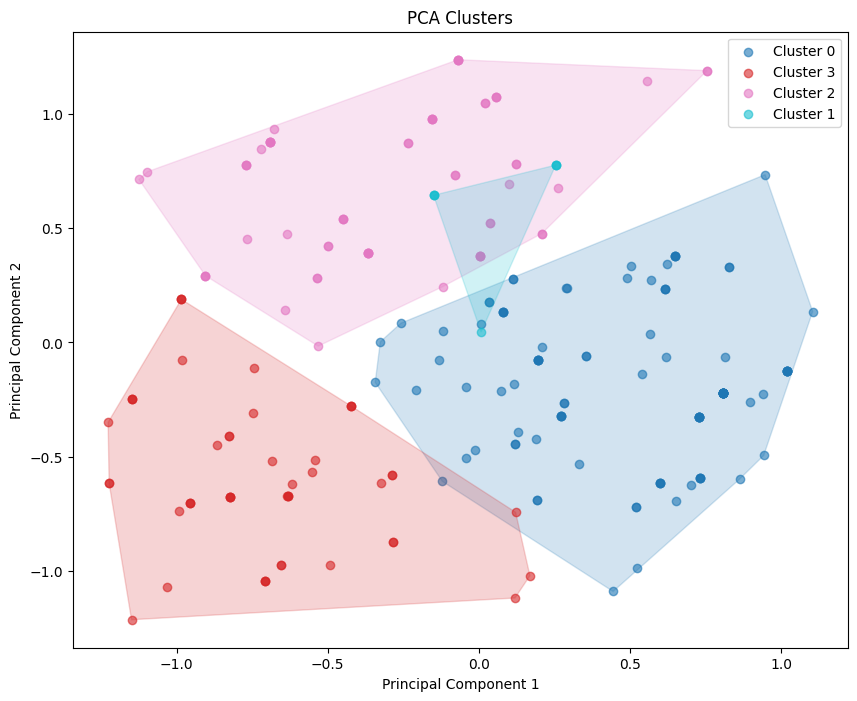

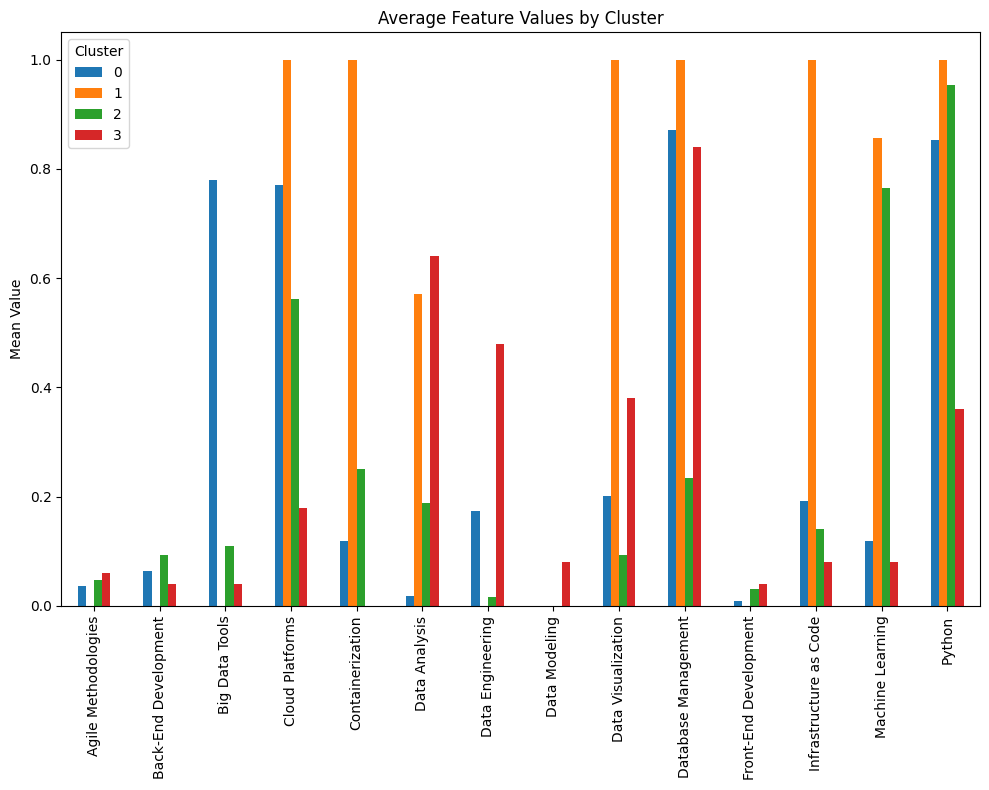

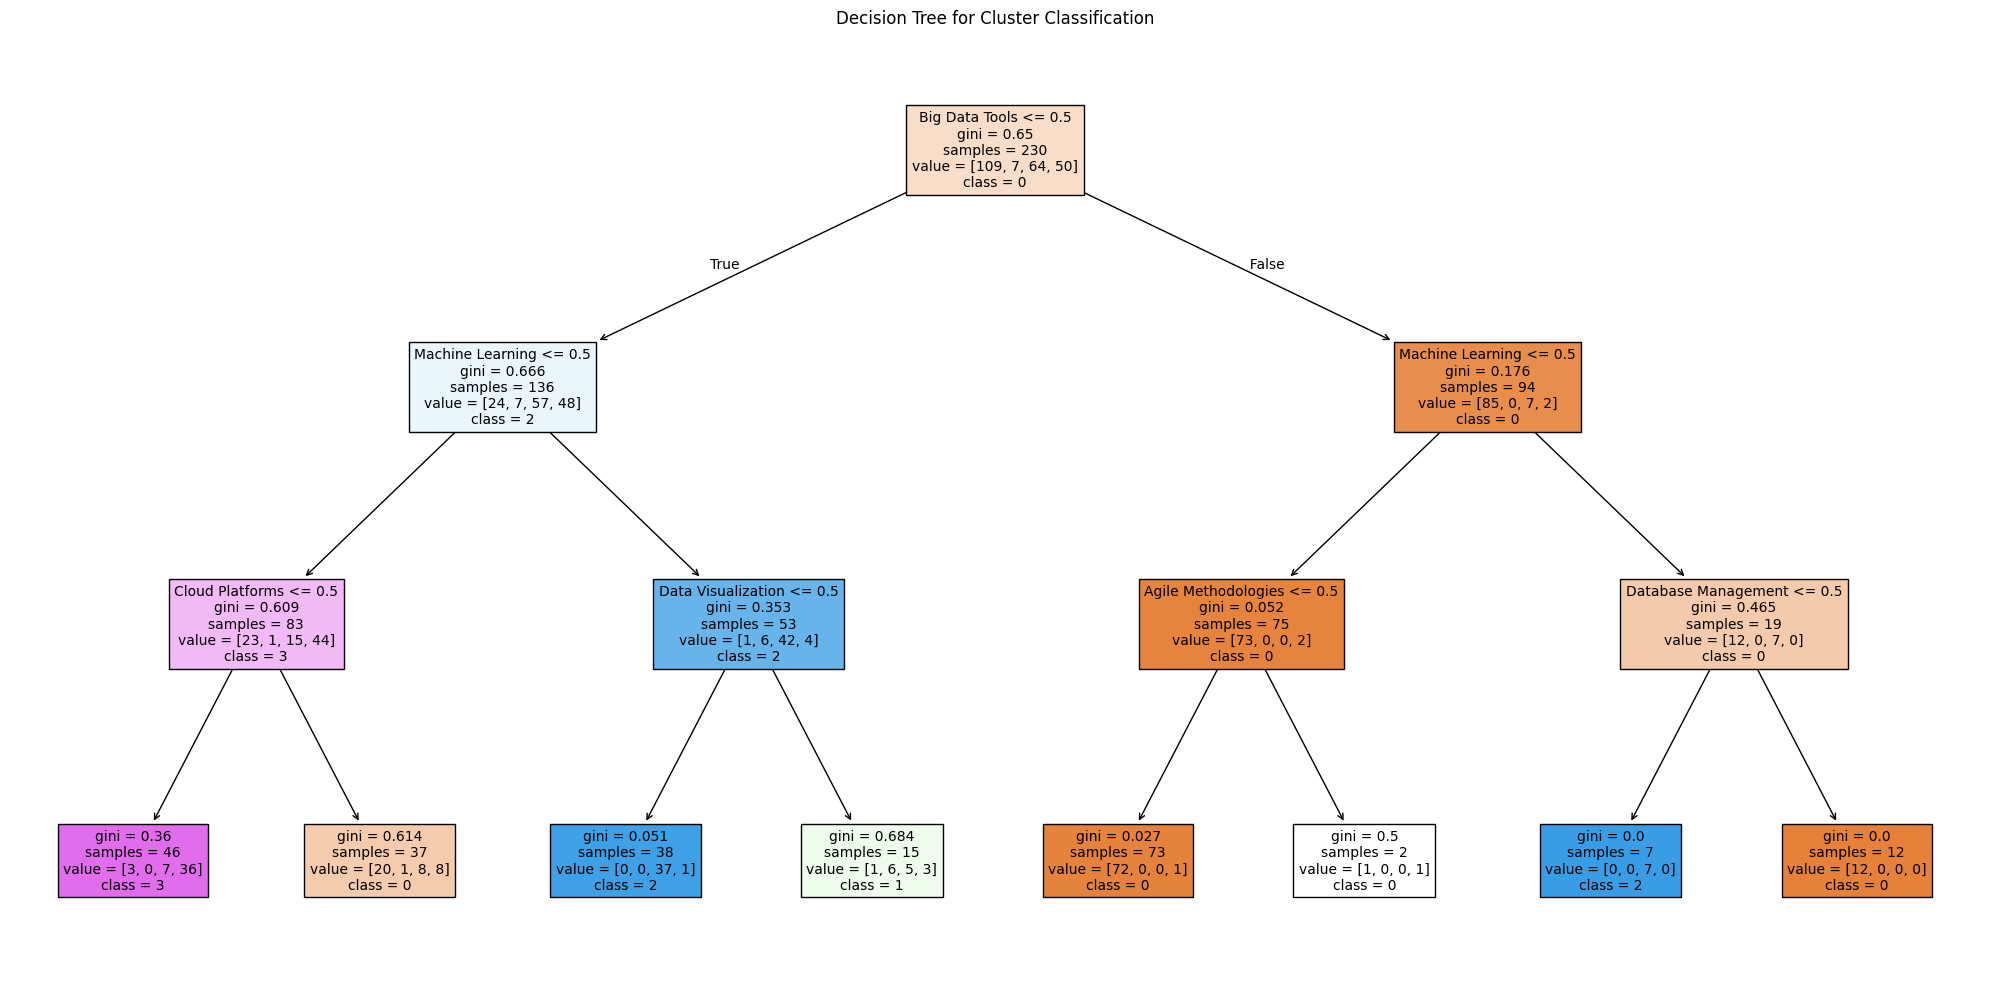

Initializing OpenAI Handler
Configuring OpenAI Client
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Example response received.


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Cluster 0
Name: Data Science Engineering and Machine Learning
Roles:
  - AI/ML and MLOps Field Engineer
  - Senior Machine Learning Engineer
  - Data Scientist
  - Data Engineer
  - Machine Learning Engineer
Characteristics: This cluster encompasses roles primarily engaged in developing, implementing, and managing data science projects and machine learning models, often requiring collaboration across technical and analytical domains. Professionals in these roles are expected to have a strong foundation in data engineering, software development, and machine learning principles.
Skills:
  - Python
  - Azure
  - AWS
  - Databricks
  - Machine Learning Frameworks

--------------------------------------------------

Cluster 1
Name: Senior Data Science and Machine Learning Research
Roles:
  - Senior Data Scientist
  - Senior Machine Learning Researcher
  - Senior Applied Scientist
  - Senior Machine Learning Engineer
Characteristics: This cluster includes senior-level roles focused on advanc

In [12]:
# Load and clean the dataset
df = pd.read_csv('LinkedIn_Jobs_Data_Scientist_Mexico.csv')
df_clean = df.dropna(subset=['EmploymentType', 'SeniorityLevel']).copy()

df_clean['English'] = df_clean['English'].apply(lambda x: 1 if x == True else 0)

df_clean.rename(columns={
    'Containerization and Orchestration': 'Containerization',
    'Infrastructure as Code (IaC) and Automation': 'Infrastructure as Code'
}, inplace=True)

#Filter dataset as needed

df_filtered = df_clean

# Define features:

categorical_columns = [
    #'Location',
    #'Remote',
    #'SeniorityLevel',
    #'EmploymentType'
]

# Define your numerical and categorical features
numerical_columns = [
    'Agile Methodologies',
    'Back-End Development',
    'Big Data Tools',
    'Cloud Platforms', 
    'Containerization',
    'Data Analysis', 
    'Data Engineering', 
    'Data Modeling', 
    'Data Visualization', 
    'Database Management', 
    #'English',
    'Front-End Development',
    'Infrastructure as Code',
    'Machine Learning', 
    'Python',
    #'Testing and Quality Assurance'
]


df_encoded = preprocess_dataframe(df_filtered, categorical_features= categorical_columns, numerical_features = numerical_columns)

best_method, df_with_clusters, n_clusters = run_best_clustering_method(df_encoded, df_filtered)

print(f'Best clustering method: {best_method}')
print(f"Best number of clusters: {n_clusters}")

# Ensure both DataFrames have a common index or key
df_encoded_with_clusters = df_encoded.copy()
df_encoded_with_clusters['Cluster'] = df_with_clusters['Cluster']
features = df_encoded.columns.tolist() 

# Plot with convex hulls and centroids
plot_pca_clusters(df_encoded_with_clusters, features, showConvexHull=True)

analyze_clusters(df_with_clusters, df_encoded_with_clusters, features, numerical_columns)

process_clusters(df_with_clusters)

In [15]:
cluster_titles_dict = df_with_clusters.groupby('Cluster')['Title'].apply(list).to_dict()

In [16]:
cluster_titles_dict

{0: ['AI/ML and MLOps Field Engineer',
  'Senior Machine Learning Engineer',
  'Data Scientist (Consultant)',
  'Data Scientist',
  'Data Engineer',
  'Data Platform Engineer Manager',
  'Data Analyst',
  'Azure Data Engineer',
  'Senior Data Engineer',
  'ML Engineer (Engineer Software Development)',
  'Sr. Data Scientist',
  'Prompt Engineer AI Data Engineer',
  'Data Monitoring Engineer (Mexico)',
  'Data Engineering Intern',
  'Data Engineers Python',
  'Data Engineer',
  'Data Engineer',
  'Data Engineer',
  'Senior Engineer - Data Engineering (MONTERREY)',
  'Azure Data Engineer',
  'Senior, Data Engineer',
  'Data Engineer (SQL)',
  'Procurement Data Engineer III',
  'Senior, Data Engineer',
  'Data Engineer',
  'Power BI Consultant',
  'Python Data Engineer',
  'Data Engineer',
  'Data Scientist',
  'Senior Data Scientist',
  'Big Data Engineer',
  'Data Engineer, Science & Data Technology team',
  'Data Cloud Engineer',
  'AWS Data Engineer',
  'Data Engineer',
  'Data & Advan